# Daily data processing and updating

This notebook will be run once a day.
It will download the daily updated datasheet, containing amount of new cases and deaths per country due to the COVID-19 virus, courtesy of https://ourworldindata.org/coronavirus-source-data

After this it will convert the data to a few dataframes that I will be working with.
Namely for for each country and date that there is information about I will 4 dataframes each containing the following attributes: new cases, new deaths, total cases, total deaths

I will comment on all steps what is happening and regularly print what we're working with for transparency.

### Data import

First we'll have to download the datasheet.
For now this can only be done locally on my machine.

In [1]:
import urllib.request               # Calls url to downlload daily file
import datetime                     # Provides current date

try:
    today = datetime.date.today()
    url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-' + str(today) + '.xlsx'

    # Second argument in urlretrieve is the destination and filename for saving
    _ = urllib.request.urlretrieve(url, 'data/daily_data.xlsx')

except: 
    yesterday = datetime.date.today() - datetime.timedelta(days=1)
    url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-' + str(yesterday) + '.xlsx'

    # Second argument in urlretrieve is the destination and filename for saving
    _ = urllib.request.urlretrieve(url, 'data/daily_data.xlsx')


Next we'll need to open the downloaded .xlsx file as a pandas dataframe so we can easelly manipulate the data.

In [2]:
import pandas as pd                # Tool to easely manipulate data

df = pd.read_excel('data/daily_data.xlsx')
df

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId,Country Code,Pop_Data.2018
0,2020-03-26,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
1,2020-03-25,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0
2,2020-03-24,24,3,2020,6,1,Afghanistan,AF,AFG,37172386.0
3,2020-03-23,23,3,2020,10,0,Afghanistan,AF,AFG,37172386.0
4,2020-03-22,22,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
...,...,...,...,...,...,...,...,...,...,...
6926,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
6927,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
6928,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
6929,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0


### Data processing

As a first step we will clean out th data a bit since we have quite some values that we do not need.

Considering the 'DateRep' column contains a datetime that Python can translate we will delete the unneeded time attributes, as well as saving the geoid's in a seperate dataset for when we need them.

In [3]:
df = df.drop(columns=['Day', 'Month', 'Year', 'GeoId'])
df

,DateRep,Cases,Deaths,Countries and territories,Country Code,Pop_Data.2018
0,2020-03-26,33,0,Afghanistan,AFG,37172386.0
1,2020-03-25,2,0,Afghanistan,AFG,37172386.0
2,2020-03-24,6,1,Afghanistan,AFG,37172386.0
3,2020-03-23,10,0,Afghanistan,AFG,37172386.0
4,2020-03-22,0,0,Afghanistan,AFG,37172386.0
...,...,...,...,...,...,...
6926,2020-03-25,0,0,Zimbabwe,ZWE,14439018.0
6927,2020-03-24,0,1,Zimbabwe,ZWE,14439018.0
6928,2020-03-23,0,0,Zimbabwe,ZWE,14439018.0
6929,2020-03-22,1,0,Zimbabwe,ZWE,14439018.0


Next, just to make our next step a little bit easier we will create two lists. One for every date, ordered from old to recent, and another for every country that can be found in the database.

In [4]:
dates = []
countries = []

for entry in df['DateRep']:
    if entry not in dates:
        dates.append(entry)

for entry in df['Countries and territories']:
    if entry not in countries:
        countries.append(entry)
        
dates.sort()

Now for the actual data extraction. 
We will start with the new cases and deaths and continue from there.

To create the structures of our dataframes we will make a list filled with tuples, which in turn contain the name of the columns we will create (in this case the 'Date' and all country names) followed by a list that holds the values of cases or deaths of that country. 
We will always follow the order of the dates list we created before when filling the lists of country values to they all line up.

At the end we convert those structure lists into dictionaries to be able to use pandas on them and convert them into dataframes.

In [5]:
struct_cases = [('Date', dates)]
struct_deaths = [('Date', dates)]
struct_populations = [('Countries', []),('Populations', [])]
i = 1

for country in countries:
    country_pop = df.loc[df['Countries and territories']==country]['Pop_Data.2018'].values[0]
    struct_populations[0][1].append(country)
    struct_populations[1][1].append(country_pop)
    
    struct_cases.append((country, []))
    struct_deaths.append((country, []))
    
    country_df = df.loc[df['Countries and territories']==country]
    collected_dates = country_df['DateRep'].tolist()
    
    for date in dates:
        if date in collected_dates:
            entry = country_df.loc[country_df['DateRep']==date]
            struct_cases[i][1].append(entry['Cases'].values[0])
            struct_deaths[i][1].append(entry['Deaths'].values[0])
            
        else:
            struct_cases[i][1].append(0)
            struct_deaths[i][1].append(0)
    
    i += 1

dict_cases = {title: content for (title, content) in struct_cases}
dict_deaths = {title: content for (title, content) in struct_deaths}
dict_populations = {title: content for (title, content) in struct_populations}

New we're finlly ready to create the dataframes for both new cases as well as new deaths for the global data.

In [6]:
df_cases_new = pd.DataFrame(dict_cases).set_index('Date')
df_cases_new = df_cases_new.fillna(0)
df_cases_new.name = 'New Cases'

df_cases_new

,Afghanistan,Angola,Albania,Andorra,Argentina,Antigua_and_Barbuda,Algeria,Armenia,Aruba,Australia,...,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,United_States_Virgin_Islands,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,0,2,6,13,67,0,0,24,0,224,...,1035,3,7123,0,25,0,0,7,0,1
2020-03-23,10,0,13,25,41,0,8,30,0,611,...,665,6,8459,0,23,13,0,24,1,0
2020-03-24,6,0,11,20,35,0,87,4,8,114,...,967,0,11236,17,4,3,48,5,0,0


In [7]:
df_deaths_new = pd.DataFrame(dict_deaths).set_index('Date')
df_deaths_new = df_deaths_new.fillna(0)
df_deaths_new.name = 'New Deaths'

df_deaths_new

,Afghanistan,Angola,Albania,Andorra,Argentina,Antigua_and_Barbuda,Algeria,Armenia,Aruba,Australia,...,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,United_States_Virgin_Islands,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,0,0,0,0,1,0,0,0,0,0,...,56,0,80,0,0,0,0,0,0,0
2020-03-23,0,0,0,0,0,0,5,0,0,0,...,48,0,131,0,0,0,0,0,0,0
2020-03-24,1,0,2,0,0,0,2,0,0,0,...,54,0,119,0,0,0,0,0,0,1


In [8]:
df_populations = pd.DataFrame(dict_populations).set_index('Countries')
df_populations = df_populations.fillna(0)
df_populations.name = 'Country populations 2018'

df_populations

,Populations
Countries,
Afghanistan,37172386.0
Angola,30809762.0
Albania,2866376.0
Andorra,77006.0
Argentina,44494502.0
...,...
Uzbekistan,32955400.0
Venezuela,28870195.0
Vietnam,95540395.0


Now the last thing that remains is to use the dataframes that we just created to create the dataframes that contain the total amount of cases and deaths.

In [9]:
df_cases_total = df_cases_new.copy()
df_cases_total.name = 'Total Cases'

for country in countries:
    count = 0
    
    for date in dates:
        count += df_cases_total.at[date, country]
        df_cases_total.at[date, country] = count
        
df_cases_total

,Afghanistan,Angola,Albania,Andorra,Argentina,Antigua_and_Barbuda,Algeria,Armenia,Aruba,Australia,...,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,United_States_Virgin_Islands,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,24,2,76,88,225,1,94,160,4,1098,...,5018,6,26747,0,135,33,36,94,2,2
2020-03-23,34,2,89,113,266,1,102,190,4,1709,...,5683,12,35206,0,158,46,36,118,3,2
2020-03-24,40,2,100,133,301,1,189,194,12,1823,...,6650,12,46442,17,162,49,84,123,3,2


In [10]:
df_deaths_total = df_deaths_new.copy()
df_deaths_total.name = 'Total Deaths'

for country in countries:
    count = 0
    
    for date in dates:
        count += df_deaths_total.at[date, country]
        df_deaths_total.at[date, country] = count
        
df_deaths_total

,Afghanistan,Angola,Albania,Andorra,Argentina,Antigua_and_Barbuda,Algeria,Armenia,Aruba,Australia,...,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,United_States_Virgin_Islands,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,0,0,2,0,4,0,10,0,0,7,...,233,0,340,0,0,0,0,0,0,0
2020-03-23,0,0,2,0,4,0,15,0,0,7,...,281,0,471,0,0,0,0,0,0,0
2020-03-24,1,0,4,0,4,0,17,0,0,7,...,335,0,590,0,0,0,0,0,0,1


### Combining data

To create the last datasets in this work sheet we will make a se containg the relative cases, meaning amount of cases over country population, and relative deaths, meaning amount of deaths over amount of cases.

Note that for now there are some 15 countries where the population data is missing.
This will resolved later by using data from gapminder.org, though for now we will eliminate these entries.

In [11]:
struct_cases_rel = [('Date', df_cases_total.index)]
struct_deaths_rel = [('Date', df_deaths_total.index)]

i = 1
j = 1

for country in df_cases_total.columns:
    if df_populations.at[country, 'Populations'] != 0:
        struct_cases_rel.append((country, []))

        for date in df_deaths_total.index:

                rel_value = df_cases_total.at[date, country] / df_populations.at[country, 'Populations']
                struct_cases_rel[i][1].append(rel_value)
            
        i +=1
        
    struct_deaths_rel.append((country, []))
    
    for date in df_deaths_total.index:
        if df_cases_total.at[date, country] != 0:
            rel_value = df_deaths_total.at[date, country] / df_cases_total.at[date, country]
            struct_deaths_rel[j][1].append(rel_value)
            
        else:
            struct_deaths_rel[j][1].append(0)
            
    j +=1

    
dict_cases_rel = {title: content for (title,content) in struct_cases_rel}
dict_deaths_rel = {title: content for (title,content) in struct_deaths_rel}

To finish with we will create one last data set to work with. Namely one containing the relative death rates, meaning total deaths over total cases.

In [12]:
df_cases_relative = pd.DataFrame(dict_cases_rel).set_index('Date')
df_cases_relative.name = 'Cases over population size'

df_cases_relative

,Afghanistan,Angola,Albania,Andorra,Argentina,Antigua_and_Barbuda,Algeria,Armenia,Aruba,Australia,...,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,United_States_Virgin_Islands,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-03,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,6.456406e-07,6.491449e-08,0.000027,0.001143,0.000005,0.000010,0.000002,0.000054,0.000038,0.000044,...,0.000075,1.065372e-07,0.000082,0.000000,0.000039,0.000001,0.000001,9.838770e-07,1.152617e-07,1.385136e-07
2020-03-23,9.146575e-07,6.491449e-08,0.000031,0.001467,0.000006,0.000010,0.000002,0.000064,0.000038,0.000068,...,0.000085,2.130744e-07,0.000108,0.000000,0.000046,0.000001,0.000001,1.235080e-06,1.728925e-07,1.385136e-07
2020-03-24,1.076068e-06,6.491449e-08,0.000035,0.001727,0.000007,0.000010,0.000004,0.000066,0.000113,0.000073,...,0.000100,2.130744e-07,0.000142,0.000159,0.000047,0.000001,0.000003,1.287414e-06,1.728925e-07,1.385136e-07


In [13]:
df_deaths_relative = pd.DataFrame(dict_deaths_rel).set_index('Date')
df_deaths_relative.name = 'Deaths over cases'


df_deaths_relative

,Afghanistan,Angola,Albania,Andorra,Argentina,Antigua_and_Barbuda,Algeria,Armenia,Aruba,Australia,...,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,United_States_Virgin_Islands,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2020-01-01,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2020-01-02,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2020-01-03,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2020-01-04,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,0.000000,0.0,0.026316,0.0,0.017778,0.0,0.106383,0.0,0.0,0.006375,...,0.046433,0.0,0.012712,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2020-03-23,0.000000,0.0,0.022472,0.0,0.015038,0.0,0.147059,0.0,0.0,0.004096,...,0.049446,0.0,0.013378,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2020-03-24,0.025000,0.0,0.040000,0.0,0.013289,0.0,0.089947,0.0,0.0,0.003840,...,0.050376,0.0,0.012704,0.0,0.0,0.0,0.0,0.0,0.0,0.500000


### Saving

With all the datasets created we can now save them to a file to be used to train networks and regression models on.
It will always save on the same file so that all other applications can just rerun when the data is updated.

In [15]:
df_cases_new.to_csv('data/cases_new.csv')
df_cases_total.to_csv('data/cases_total.csv')

df_deaths_new.to_csv('data/deaths_new.csv')
df_deaths_total.to_csv('data/deaths_total.csv')

df_cases_relative.to_csv('data/cases_relative.csv')
df_deaths_relative.to_csv('data/deaths_relative.csv')

df_populations.to_csv('data/populations_2018.csv')

### Final example

To show how we will be using these dataframes, besides training models and networks, we will create a function to plot the data that we have for a set of countries.

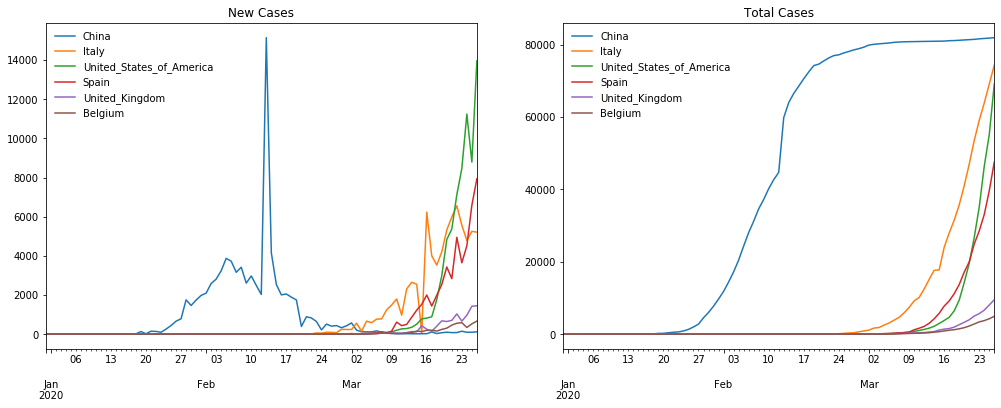

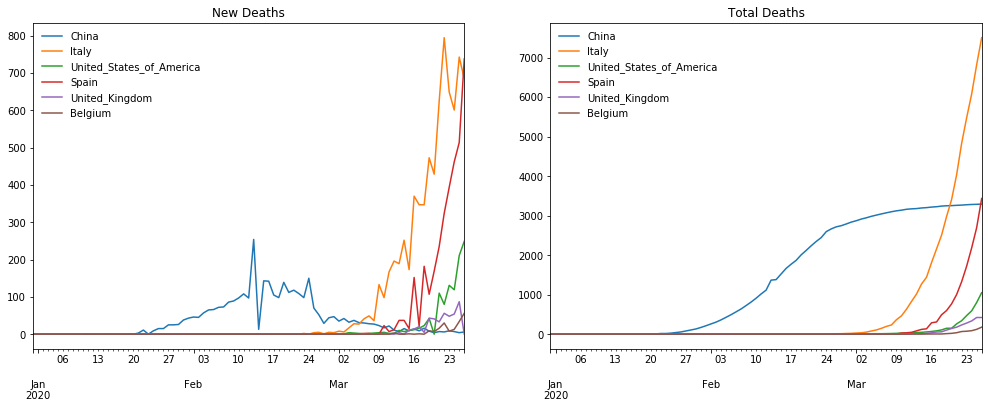

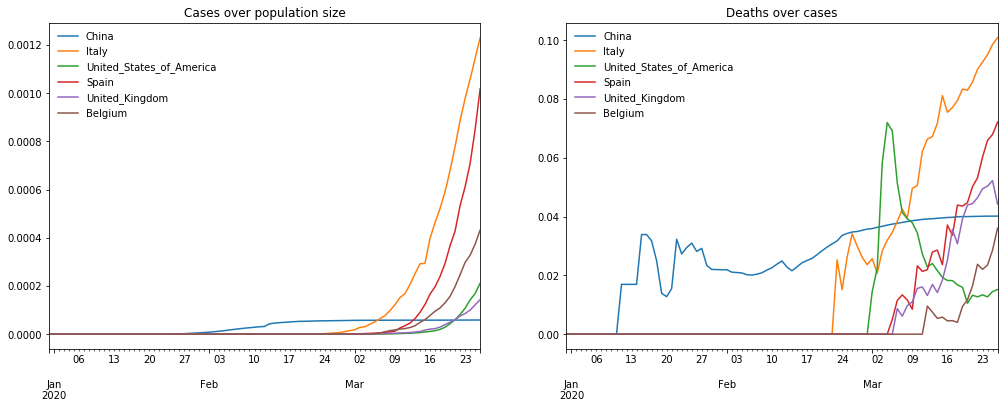

In [65]:
import matplotlib.pyplot as plt

countries_to_see = ['China', 'Italy', 'United_States_of_America', 'Spain', 'United_Kingdom', 'Belgium']

def plot_side_by_side(df1, df2):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    df1[countries_to_see].plot(figsize=(17,6), ax=ax1)
    ax1.legend(frameon=False, loc='upper left')
    ax1.set_xlabel('')
    ax1.set_title(df1.name)
    
    df2[countries_to_see].plot(figsize=(17,6), ax=ax2)
    ax2.legend(frameon=False, loc='upper left')
    ax2.set_xlabel('')
    ax2.set_title(df2.name)
    
    plt.show()

plot_side_by_side(df_cases_new, df_cases_total)
plot_side_by_side(df_deaths_new, df_deaths_total)
plot_side_by_side(df_cases_relative, df_deaths_relative)